In [1]:
import os
import cv2
import random
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
from Utilities import Utilities
import warnings
warnings.filterwarnings('ignore')

#### Stacked Hourglass Network

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)

In [ ]:
class Hourglass(nn.Module):
    def __init__(self, depth, num_features, num_blocks):
        super().__init__()
        self.depth = depth                # уровни "песочных часов"
        self.num_features = num_features  # каналы признаков на входе/выходе ветвей
        self.num_blocks = num_blocks      # остаточные блоки в каждой ветви
        # Прямая обработка входного тензора
        self.upper_branch = self._make_branch(num_blocks, num_features, num_features)
        # Обработка после понижения разрешения
        self.lower_branch = self._make_branch(num_blocks, num_features, num_features)
        self.pool = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # рекурсия
        if self.depth > 1:
            # следующий уровень "пеcочных часов"
            self.inner_hourglass = Hourglass(depth - 1, num_features, num_blocks)
        else:
            self.inner_residual = self._make_branch(num_blocks, num_features, num_features)

    def _make_branch(self, num_blocks, in_channels, out_channels):
        # Остаточные блоки
        layers = []
        for _ in range(num_blocks):
            layers.append(ResidualBlock(in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        upper_out = self.upper_branch(x)
        pooled = self.pool(x)
        if self.depth > 1:
            inner_out = self.inner_hourglass(pooled)
        else:
            inner_out = self.inner_residual(pooled)
        lower_out = self.lower_branch(inner_out)
        upsampled = self.upsample(lower_out)
        return upsampled + upper_out

In [ ]:
class StackedHourglass(nn.Module):
    def __init__(self, num_stacks, num_blocks, num_classes, in_channels=3):
        super().__init__()
        self.num_stacks = num_stacks   # "этажи" песочных часов 
        self.in_channels = in_channels # входные каналы
        self.num_classes = num_classes # число ключевых точек

        # Предварительная обработка входного изображения
        self.pre_processing = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResidualBlock(64, 128),
            nn.MaxPool2d(2, 2),
            ResidualBlock(128, 128),
            ResidualBlock(128, 256)
        )
        
        # Список песочных часов
        self.hourglass_stack = nn.ModuleList([
            Hourglass(depth=4, num_features=256, num_blocks=num_blocks)
            for _ in range(num_stacks)
        ])

        # Головы для предсказания heatmap
        self.heatmap_heads = nn.ModuleList([
            self._make_head(256, num_classes) for _ in range(num_stacks)
        ])

        # предсказания признаков между стеками. кроме последнего 
        self.feature_remaps = nn.ModuleList([
            nn.Conv2d(256, 256, kernel_size=1) for _ in range(num_stacks - 1)
        ])

        # преобразования предсказаний между стеками. кроме последнего 
        self.prediction_remaps = nn.ModuleList([
            nn.Conv2d(num_classes, 256, kernel_size=1) for _ in range(num_stacks - 1)
        ])

    def _make_head(self, in_channels, out_channels):
        # предсказания heatmap 
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
        )

    def forward(self, x):
        features = self.pre_processing(x)
        all_heatmaps = []
        for i in range(self.num_stacks):
            hourglass_out = self.hourglass_stack[i](features)
            heatmap = self.heatmap_heads[i](hourglass_out)
            all_heatmaps.append(heatmap)
            if i < self.num_stacks - 1:
                features_remap = self.feature_remaps[i](hourglass_out)
                preds_remap = self.prediction_remaps[i](heatmap)
                features = features + features_remap + preds_remap

        return all_heatmaps

In [7]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class CelebAHeatmapDataset(Dataset):
    def __init__(self, root_dir, file_landmarks, input_size, output_size, faces=True):
        self.root_dir = root_dir
        self.input_size = input_size
        self.output_size = output_size
        self.scale_factor = input_size / output_size
        self.file_landmarks = []
        self.faces = faces

        # Читаем файл с landmark'ами
        with open(os.path.join(root_dir, file_landmarks), 'r') as file:
            # Пропускаем заголовок (если есть)
            _ = file.readline()
            for line in file:
                line = line.strip()
                if not line:
                    continue
                parts = line.split(',')
                # Первый элемент — имя файла, остальные — координаты
                filename = parts[0]
                landmarks = [float(x) for x in parts[1:]]  # Безопасное преобразование
                self.file_landmarks.append([filename] + landmarks)

        self.transform = transforms.Compose([
            transforms.Resize((self.input_size, self.input_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.file_landmarks)

    def __getitem__(self, idx):
        # Получаем имя файла и landmark'и
        filename = self.file_landmarks[idx][0]
        landmarks = self.file_landmarks[idx][1:]
 
        # Загружаем изображение
        if self.faces:
          image_path = os.path.join(self.root_dir, 'faces', filename)
        else:
          image_path = os.path.join(self.root_dir, filename)

        image = Image.open(image_path).convert('RGB')

        # Преобразуем landmark'и в массив [(x1, y1), (x2, y2), ...]
        landmarks = np.array([(landmarks[i], landmarks[i+1]) for i in range(0, len(landmarks), 2)])

        # Масштабируем landmark'и под input_size
        image_shape = image.size  # (width, height)
        landmarks[:, 0] *= self.input_size / image_shape[0]  # x
        landmarks[:, 1] *= self.input_size / image_shape[1]  # y
        landmarks_for_heatmap = landmarks / self.scale_factor

        # Создаём heatmap'ы
        heatmaps = Utilities.landmarks_to_heatmaps((self.output_size, self.output_size), landmarks_for_heatmap, sigma=1.5)

        # Преобразуем изображение в тензор
        image_tensor = self.transform(image)

        return image_tensor, torch.from_numpy(heatmaps).float(), torch.from_numpy(landmarks).float(), filename

##### Загрузка отобранных 10000+ лиц и разделение на обучающую, валидационную и тестовую выборки

In [ ]:
root_dir =  os.path('C:\\', 'DLS', '10000')

In [ ]:
dataset = CelebAHeatmapDataset(root_dir, 'landmarks_10000.csv', 256, 64)

len_dataset = len(dataset)
train_size = int(0.7 * len_dataset)
val_size = int(0.15 * len_dataset)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # для воспроизводимости
)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
os.makedirs(os.path.join(root_dir, 'save'), exist_ok=True)
torch.save(train_dataset, os.path.join(root_dir, 'save', 'train_indices.pt'))
torch.save(val_dataset, os.path.join(root_dir, 'save', 'val_indices.pt'))
torch.save(test_dataset, os.path.join(root_dir, 'save', 'test_indices.pt'))

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Обучение модели

##### Данные для обучения

In [11]:
num_stacks = 2 # Hourglass-блоки
num_blocks = 4 # Residual-блоки в ветвях Hourglass
num_classes = 5 # глаза, нос, рот
model = StackedHourglass(num_stacks, num_blocks, num_classes).to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

epochs = 25

##### Обучение

In [12]:
def fit(model, train_loader, val_loader, optimizer, criterion, epochs, scheduler=None):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        torch.cuda.empty_cache()
        model.train()
        total_train_loss = 0.0
        for images, heatmaps, _, _ in tqdm(train_loader):
                images = images.to(device)
                heatmaps = heatmaps.to(device)
                optimizer.zero_grad()
                predicted_heatmaps = model(images)
                loss = 0
                for pred_hm in predicted_heatmaps:
                    loss += criterion(pred_hm, heatmaps)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for images, heatmaps, _, _ in tqdm(val_loader):
                images = images.to(device)
                heatmaps = heatmaps.to(device)
                predicted_heatmaps = model(images)
                loss = 0
                for pred_hm in predicted_heatmaps:
                    loss += criterion(pred_hm, heatmaps)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1} Avg train loss: {avg_train_loss:.4f} Avg val loss: {avg_val_loss:.4f}')

        if scheduler:
            scheduler.step()

    return model, train_losses, val_losses


In [13]:
model, train_losses, val_losses = fit(model, train_loader, val_loader, optimizer, criterion, epochs, scheduler)

100%|██████████| 659/659 [03:01<00:00,  3.63it/s]


Epoch 1 Avg train loss: 0.0025 Avg val loss: 0.0006


100%|██████████| 659/659 [02:05<00:00,  5.24it/s]


Epoch 2 Avg train loss: 0.0005 Avg val loss: 0.0004


100%|██████████| 659/659 [02:02<00:00,  5.40it/s]


Epoch 3 Avg train loss: 0.0003 Avg val loss: 0.0003


100%|██████████| 659/659 [02:04<00:00,  5.28it/s]


Epoch 4 Avg train loss: 0.0003 Avg val loss: 0.0003


100%|██████████| 659/659 [02:09<00:00,  5.08it/s]


Epoch 5 Avg train loss: 0.0003 Avg val loss: 0.0003


100%|██████████| 659/659 [02:02<00:00,  5.39it/s]


Epoch 6 Avg train loss: 0.0002 Avg val loss: 0.0003


100%|██████████| 659/659 [02:02<00:00,  5.38it/s]


Epoch 7 Avg train loss: 0.0002 Avg val loss: 0.0003


100%|██████████| 659/659 [02:02<00:00,  5.40it/s]


Epoch 8 Avg train loss: 0.0002 Avg val loss: 0.0003


100%|██████████| 659/659 [02:02<00:00,  5.39it/s]


Epoch 9 Avg train loss: 0.0002 Avg val loss: 0.0003


100%|██████████| 659/659 [02:02<00:00,  5.39it/s]


Epoch 10 Avg train loss: 0.0002 Avg val loss: 0.0003


100%|██████████| 659/659 [02:02<00:00,  5.39it/s]


Epoch 11 Avg train loss: 0.0002 Avg val loss: 0.0003


100%|██████████| 659/659 [02:04<00:00,  5.31it/s]


Epoch 12 Avg train loss: 0.0002 Avg val loss: 0.0003


100%|██████████| 659/659 [02:05<00:00,  5.24it/s]


Epoch 13 Avg train loss: 0.0002 Avg val loss: 0.0003


100%|██████████| 659/659 [02:03<00:00,  5.32it/s]


Epoch 14 Avg train loss: 0.0002 Avg val loss: 0.0003


100%|██████████| 659/659 [02:04<00:00,  5.30it/s]


Epoch 15 Avg train loss: 0.0002 Avg val loss: 0.0003


100%|██████████| 659/659 [02:02<00:00,  5.38it/s]


Epoch 16 Avg train loss: 0.0002 Avg val loss: 0.0003


100%|██████████| 659/659 [03:30<00:00,  3.13it/s]


Epoch 17 Avg train loss: 0.0002 Avg val loss: 0.0003


100%|██████████| 659/659 [02:37<00:00,  4.20it/s]


Epoch 18 Avg train loss: 0.0002 Avg val loss: 0.0003


100%|██████████| 659/659 [02:36<00:00,  4.21it/s]


Epoch 19 Avg train loss: 0.0002 Avg val loss: 0.0003


100%|██████████| 659/659 [02:35<00:00,  4.23it/s]


Epoch 20 Avg train loss: 0.0002 Avg val loss: 0.0003


100%|██████████| 659/659 [02:02<00:00,  5.38it/s]


Epoch 21 Avg train loss: 0.0002 Avg val loss: 0.0003


100%|██████████| 659/659 [02:02<00:00,  5.39it/s]


Epoch 22 Avg train loss: 0.0002 Avg val loss: 0.0003


100%|██████████| 659/659 [02:02<00:00,  5.40it/s]


Epoch 23 Avg train loss: 0.0002 Avg val loss: 0.0003


100%|██████████| 659/659 [02:02<00:00,  5.38it/s]


Epoch 24 Avg train loss: 0.0002 Avg val loss: 0.0003


100%|██████████| 659/659 [02:01<00:00,  5.42it/s]

Epoch 25 Avg train loss: 0.0002 Avg val loss: 0.0003


In [14]:
os.makedirs(os.path.join(root_dir, 'save'), exist_ok=True)
torch.save(model.state_dict(), os.path.join(root_dir, 'save', 'model.pt'))
torch.save(train_losses, os.path.join(root_dir, 'save', 'train_losses.pt'))
torch.save(val_losses, os.path.join(root_dir, 'save', 'val_losses.pt'))

##### Графики лоссов

In [15]:
def plot_losses(epochs, train_losses, val_losses):
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, epochs + 1), train_losses, label='train loss')
  plt.plot(range(1, epochs + 1), val_losses, label='val loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.title('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

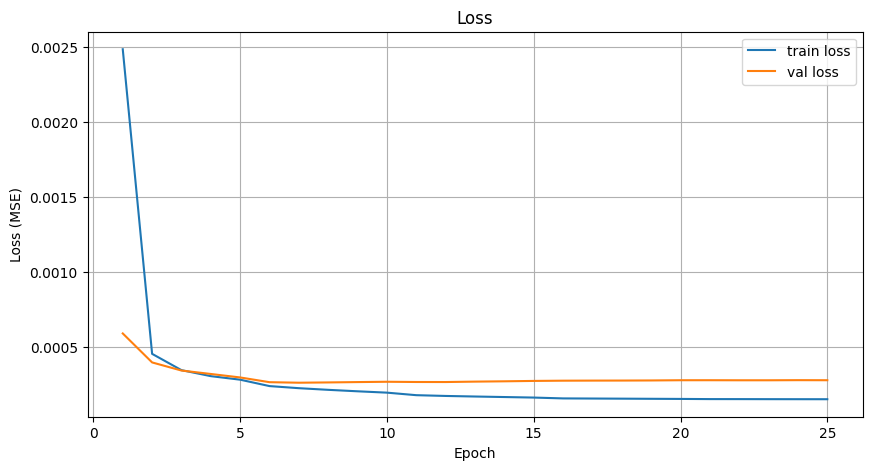

In [16]:
plot_losses(epochs, train_losses, val_losses)

##### Предсказанные точки и hitmaps

In [17]:
class View_Points_Hitmaps:
    def __init__(self, model, dataset, idx, predict=True):
            if hasattr(dataset, 'dataset')  and predict:
                self.input_size = dataset.dataset.input_size
                self.output_size = dataset.dataset.output_size
                self.predict = True
            else:
                self.input_size = dataset.input_size
                self.output_size = dataset.output_size
                self.predict = False
            self.idx = idx
            self.model = model
            self.dataset = dataset

    def fit(self):
            if self.predict:
                image_tensor, target_heatmaps, _, _ = self.dataset[self.idx]
                image_tensor = image_tensor.unsqueeze(0).to(device)

                with torch.no_grad():
                    self.predicted_heatmaps = model(image_tensor)[-1] 

                scale_factor = self.input_size / self.output_size
                self.pred_landmarks = Utilities.post_process_landmarks(self.predicted_heatmaps, scale_factor)[0]

                img_display = image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img_display = std * img_display + mean
                self.img_display = np.clip(img_display, 0, 1)
            else:
                self.img_display = self.dataset[self.idx][0].squeeze().cpu().numpy().transpose(1, 2, 0)
                self.img_display = np.clip(self.img_display, 0, 1)
            
            
    def show(self):        
            plt.figure(figsize=(10, 6))
            self.fit()
            self.show_points()
            self.show_heatmaps()
            
    def show_points(self):
            plt.subplot(1, 3, 1)
            plt.imshow(self.img_display)
            if self.predict:
                plt.scatter(self.pred_landmarks[:, 0], self.pred_landmarks[:, 1], c='r', s=40, marker='x')
            else:
                plt.scatter(self.dataset[self.idx][2][:, 0], self.dataset[self.idx][2][:, 1], c='r', s=40, marker='x')            
            plt.title("Точки")
            plt.axis('off')

    def show_heatmaps(self):
            plt.subplot(1, 3, 2)
            if self.predict:
                combined_heatmap = self.predicted_heatmaps.squeeze().cpu().numpy().sum(axis=0)
            else:
                combined_heatmap = self.dataset[self.idx][1].squeeze().cpu().numpy().sum(axis=0)     
            plt.imshow(combined_heatmap, cmap='hot')
            plt.title("Heatmaps")
            plt.axis('off')
            plt.show()


In [18]:
model.load_state_dict(torch.load(os.path.join(root_dir, 'save', 'model.pt')))

<All keys matched successfully>

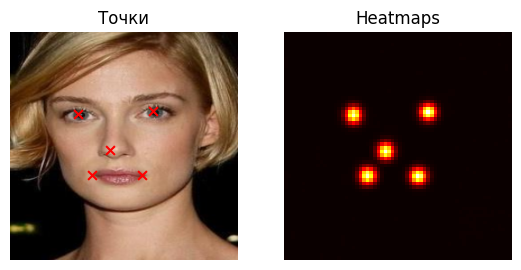

In [19]:
view_points_hitmaps_train = View_Points_Hitmaps(model, train_dataset, 1)
view_points_hitmaps_train.show()

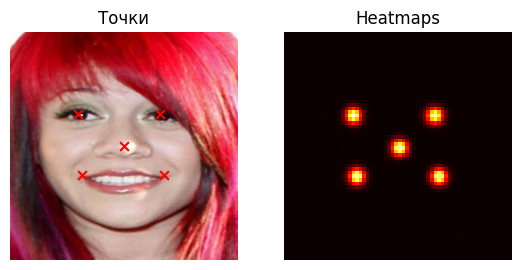

In [20]:
view_points_hitmaps_val = View_Points_Hitmaps(model, val_dataset, 1)
view_points_hitmaps_val.show()

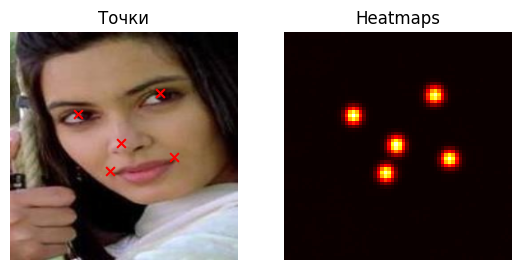

In [21]:
view_points_hitmaps_test = View_Points_Hitmaps(model,test_dataset, 0)
view_points_hitmaps_test.show()

##### Выравниваем лица

  0%|          | 0/70290 [00:00<?, ?it/s]

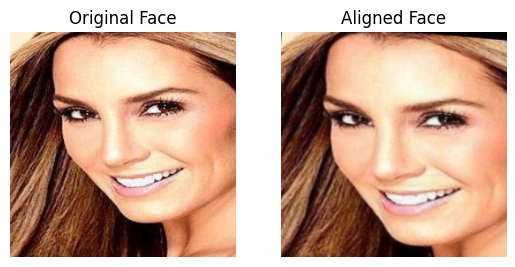

  9%|▉         | 6478/70290 [09:51<1:39:59, 10.64it/s]

Предупреждение: dist=0, используем scale=1.0


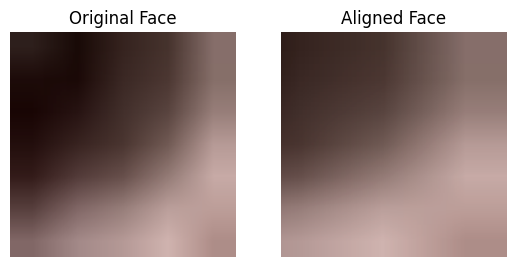

 14%|█▍        | 9999/70290 [15:24<1:30:16, 11.13it/s]

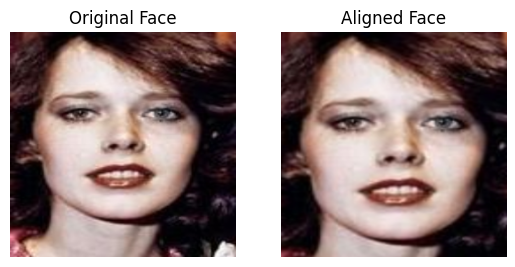

 18%|█▊        | 12631/70290 [19:32<1:29:15, 10.77it/s]

Предупреждение: dist=0, используем scale=1.0


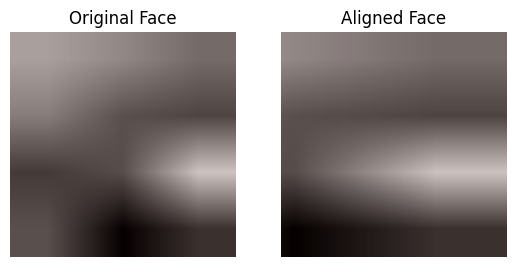

 19%|█▉        | 13233/70290 [20:28<1:29:24, 10.64it/s]

Предупреждение: dist=0, используем scale=1.0


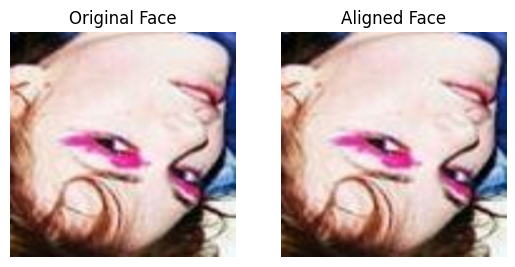

 25%|██▌       | 17786/70290 [27:34<1:21:49, 10.69it/s]

Предупреждение: dist=0, используем scale=1.0


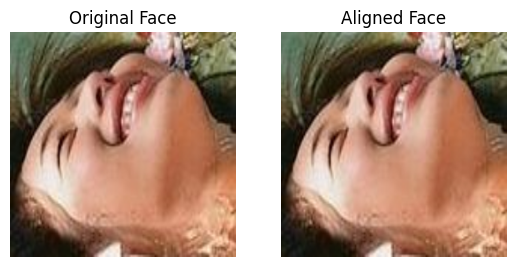

 28%|██▊       | 19999/70290 [31:04<1:19:34, 10.53it/s]

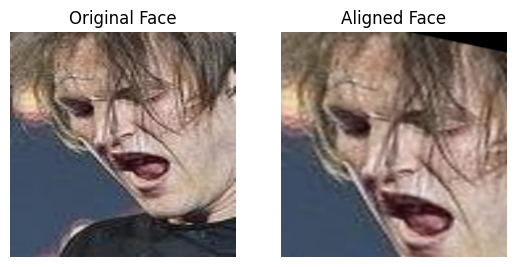

 43%|████▎     | 29999/70290 [46:50<1:03:06, 10.64it/s]

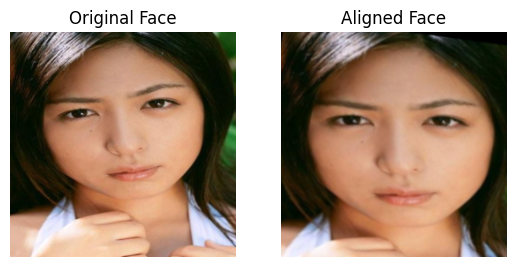

 48%|████▊     | 33898/70290 [53:00<56:58, 10.64it/s]  

Предупреждение: dist=0, используем scale=1.0


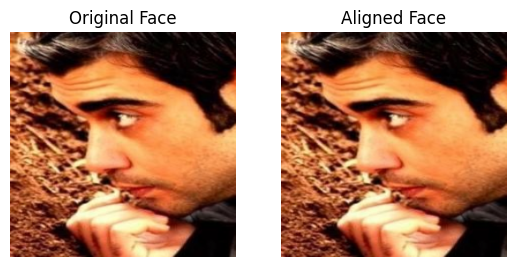

 57%|█████▋    | 39904/70290 [1:02:26<46:58, 10.78it/s]  

Предупреждение: dist=0, используем scale=1.0


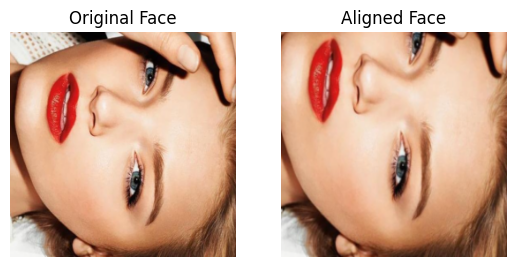

 57%|█████▋    | 40000/70290 [1:02:36<46:28, 10.86it/s]

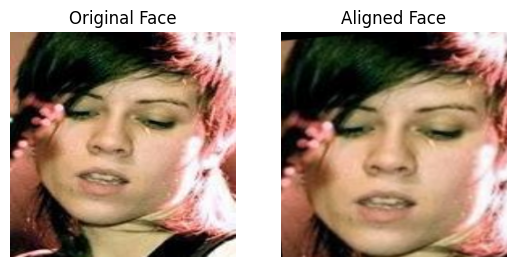

 71%|███████   | 49999/70290 [1:18:21<31:23, 10.77it/s]

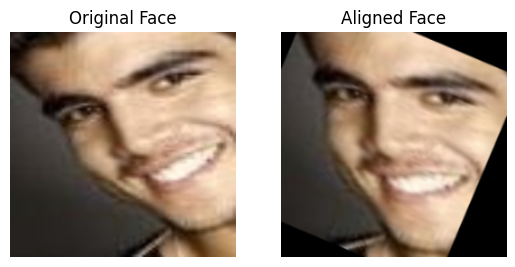

 85%|████████▌ | 60000/70290 [1:34:10<18:08,  9.45it/s]

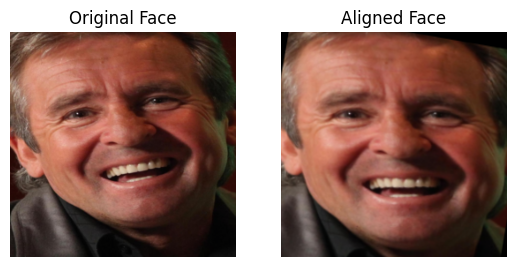

 92%|█████████▏| 65016/70290 [1:42:03<08:04, 10.89it/s]

Предупреждение: dist=0, используем scale=1.0


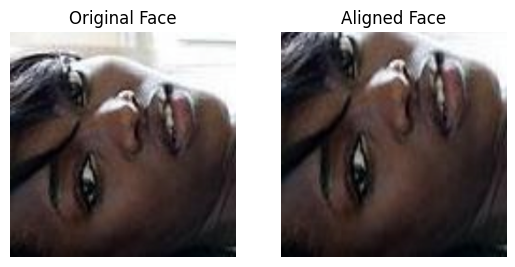

100%|█████████▉| 69999/70290 [1:49:54<00:27, 10.53it/s]

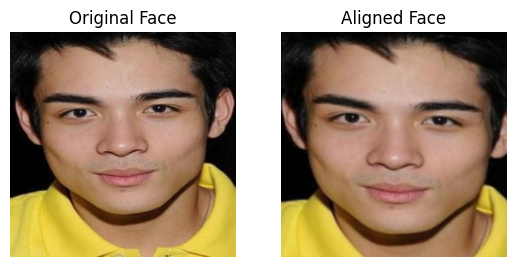

100%|██████████| 70290/70290 [1:50:21<00:00, 10.61it/s]


In [22]:
os.makedirs(os.path.join(root_dir, 'face alignment'), exist_ok=True)


for img_idx in tqdm(range(len_dataset)):
    image_tensor, target_heatmaps, _, filename = dataset[img_idx]
    image_tensor = image_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        predicted_heatmaps = model(image_tensor)[-1]
    input_size = val_dataset.dataset.input_size
    output_size = val_dataset.dataset.output_size
    scale_factor = input_size / output_size
    pred_landmarks = Utilities.post_process_landmarks(predicted_heatmaps, scale_factor)[0]
    img_display = image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1)

    img_bgr = cv2.cvtColor((img_display * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

    aligned_face, dist_zero = Utilities.align_face_by_rotation(img_bgr, pred_landmarks)

    aligned_face_rgb = cv2.cvtColor(aligned_face, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(os.path.join(root_dir, 'face alignment', filename), aligned_face)
    if img_idx % 10000 == 0 or dist_zero:
        plt.subplot(1, 2, 1)
        plt.imshow(img_display)
        plt.title("Original Face")
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(aligned_face_rgb)
        plt.title("Aligned Face")
        plt.axis('off')
        plt.show()

